     output       t-1     t-168       t-2      t-24       t-3  d_0  d_1  d_2  \
0  0.487643  0.530786  0.470714  0.595214  0.486286  0.633857    0    0    0   
1  0.558643  0.553929  0.597857  0.551714  0.581786  0.549929    0    1    0   
2  0.387214  0.382571  0.372929  0.375786  0.435786  0.355786    0    0    0   
3  0.363571  0.359500  0.398000  0.364786  0.355071  0.375286    0    0    1   
4  0.358643  0.331643  0.352500  0.333571  0.327214  0.328286    0    0    0   

   d_3  d_4  d_5  d_6  SD  
0    0    0    1    0   0  
1    0    0    0    0   0  
2    0    1    0    0   0  
3    0    0    0    0   0  
4    0    0    1    0   0  


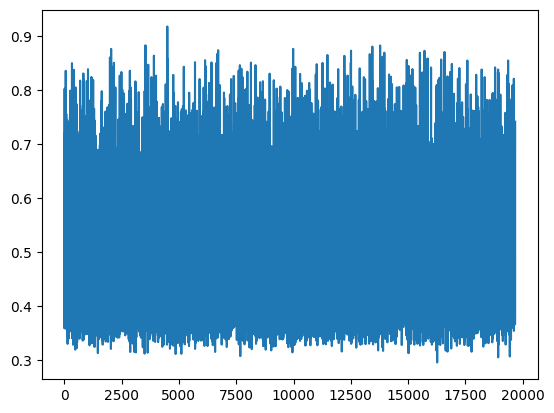

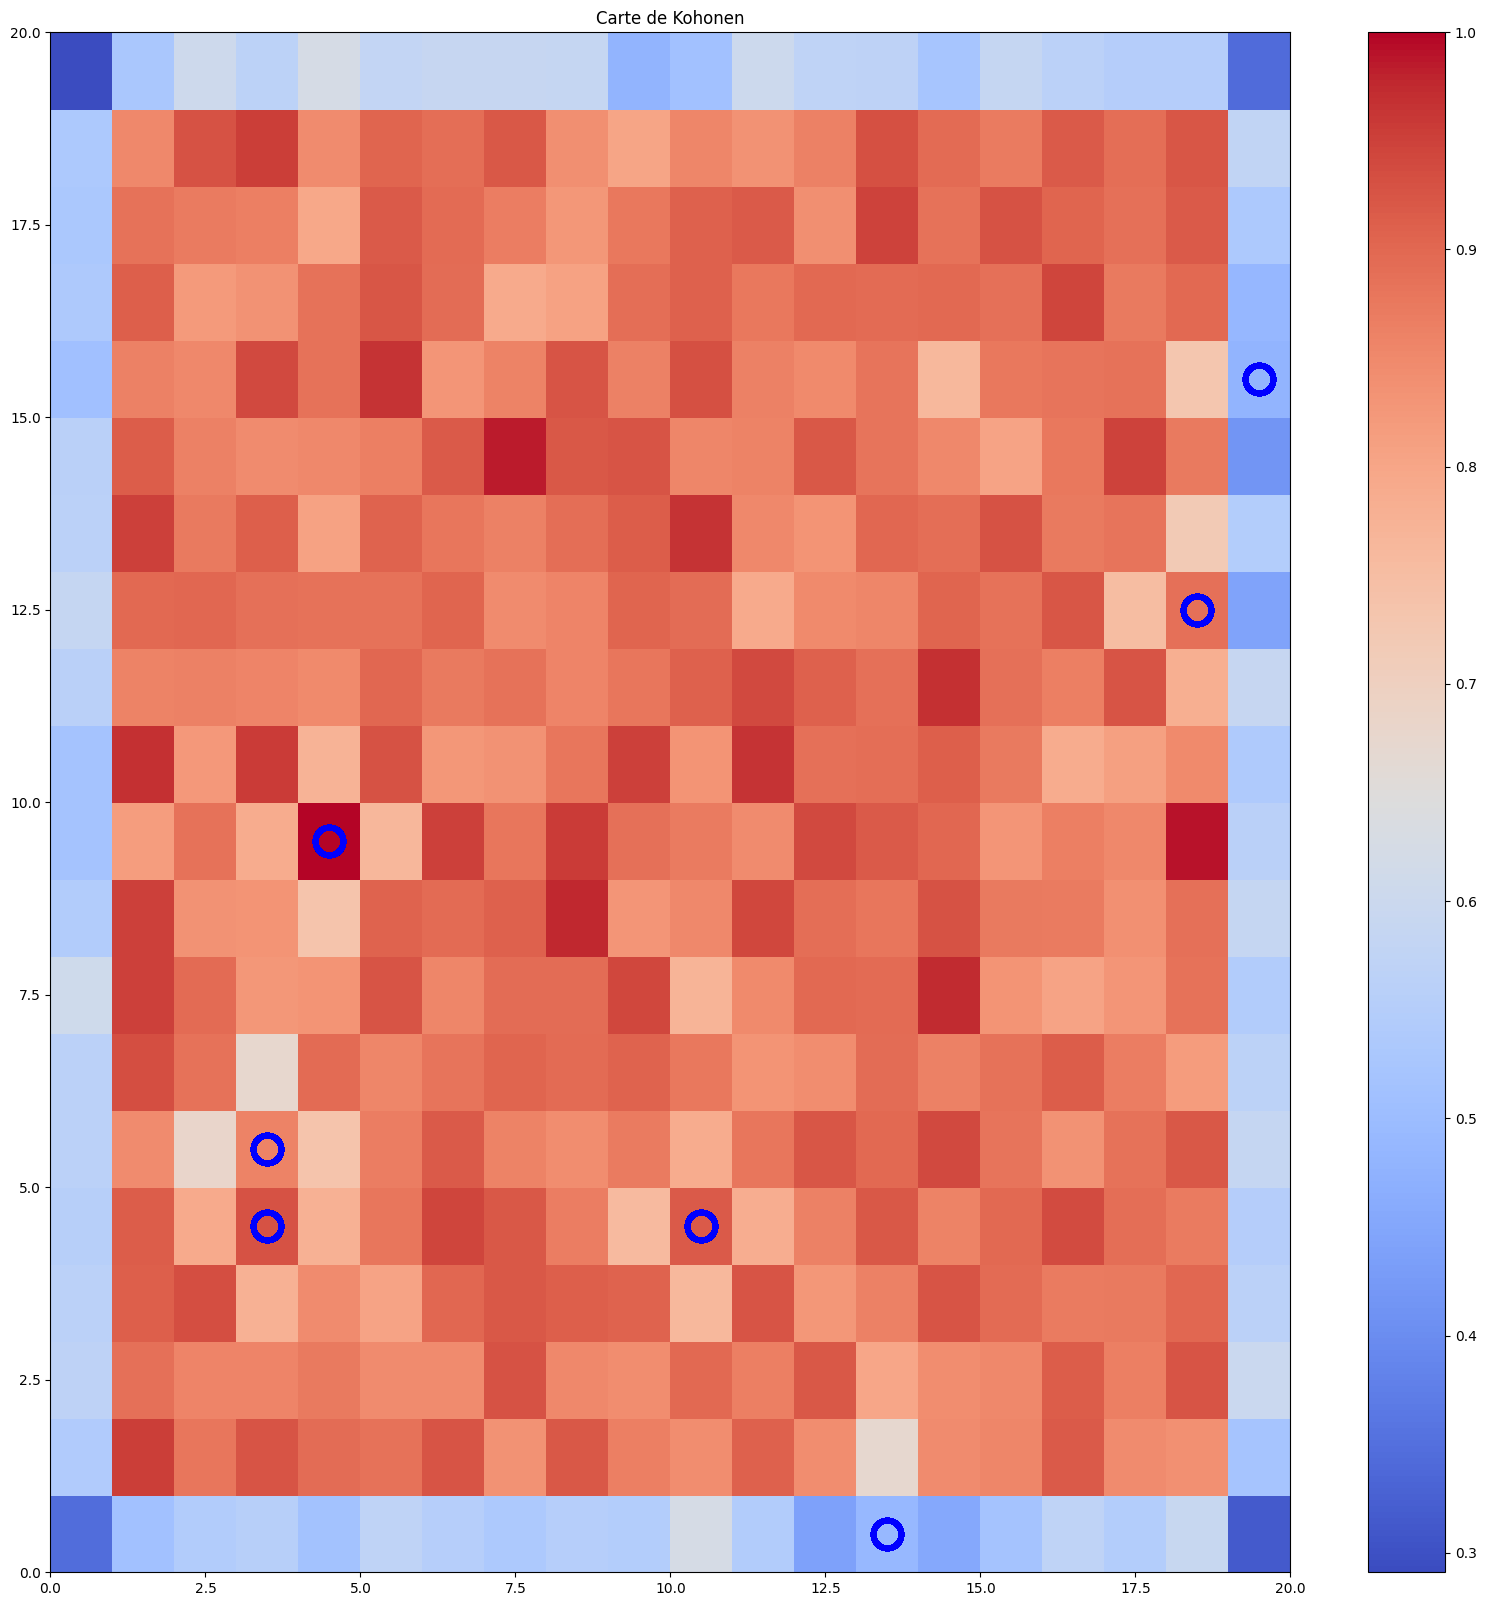

Nombre de classes trouvées : 7


In [104]:
#L'Identification des Classes avec la Carte de Kohonen

import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from google.colab import files

# Charger les données train à partir du fichier CSV
x_train = pd.read_csv('train.csv', index_col=0, parse_dates=[0])

# Réinitialiser l'index du DataFrame
x_train.reset_index(drop=True, inplace=True)

load_train = x_train['output']

print(x_train.head())

plt.plot(load_train)
plt.show()

# Paramètres de la carte de Kohonen
som_shape = (20, 20)  # Taille de la carte
input_len = len(x_train.columns)  # Nombre de features

# Création et entraînement de la carte de Kohonen
som = MiniSom(som_shape[0], som_shape[1], input_len, sigma=0.5, learning_rate=0.3)
som.train_random(x_train.values, 1000)  # Entraînement avec 1000 itérations

# Affichage de la carte de Kohonen
plt.figure(figsize=(20, 20))
for i, x in enumerate(x_train.values):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='None', markeredgecolor='b', markersize=20, markeredgewidth=4)

plt.pcolor(som.distance_map().T, cmap='coolwarm')  # Afficher la distance entre les neurones
plt.colorbar()

# Affichage
plt.title('Carte de Kohonen')
plt.show()

# Calcul du nombre de classes trouvées
unique_classes = len(set([som.winner(x) for x in x_train.values]))
print("Nombre de classes trouvées :", unique_classes)


# Trouver les neurones gagnants pour chaque exemple dans les données d'entraînement
winning_neurons = [som.winner(x) for x in x_train.values]

# Créer un dictionnaire des indices de classe pour chaque neurone gagnant
cluster_indices = {}
for idx, neuron in enumerate(winning_neurons):
    cluster_indices[tuple(neuron)] = idx

# Ajouter la colonne de classe aux données d'entraînement
x_train['cluster'] = [cluster_indices[tuple(x)] for x in winning_neurons]

# Enregistrer dans un fichier CSV
file_name = "Classed_Train_data.csv"
x_train.to_csv(file_name, index=False)


In [4]:
# La Prévision avec RBF

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
import warnings
from datetime import datetime, timedelta


# Fonctions pour normaliser et dénormaliser les données
def normalize_decimal(data, power=14000):
    return data / power

def denormalize_decimal(data, power=14000):
    return data * power

# Chargement des données d'entraînement et de validation
train_data = pd.read_csv('train.csv')
validation_data = pd.read_csv('validation.csv')

# Séparation des features et de la cible
X_train = train_data[['t-1', 't-2', 't-3', 't-24', 't-168']]
y_train = train_data['output']
X_val = validation_data[['t-1', 't-2', 't-3', 't-24', 't-168']]
y_val = validation_data['output']

# Normalisation des features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Effectuer le clustering K-means sur les données d'entraînement
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X_train_scaled)

# Ajouter les étiquettes de cluster en tant que nouvelles fonctionnalités
X_train_with_clusters = pd.concat([X_train, pd.DataFrame(kmeans.labels_, columns=['cluster'])], axis=1)
X_val_with_clusters = pd.concat([X_val, pd.DataFrame(kmeans.predict(X_val_scaled), columns=['cluster'])], axis=1)

# Entraînement du modèle avec la classe RBF
rbf_feature = RBFSampler(gamma=1, random_state=42, n_components=500)
X_train_rbf = rbf_feature.fit_transform(X_train_with_clusters)
X_val_rbf = rbf_feature.transform(X_val_with_clusters)

# Utilisation d'un modèle linéaire pour la régression
rbf_model_with_clusters = Ridge(alpha=1.0)
rbf_model_with_clusters.fit(X_train_rbf, y_train)

# Évaluation du modèle avec clustering
y_val_pred_with_clusters = rbf_model_with_clusters.predict(X_val_rbf)
mse_with_clusters = mean_squared_error(y_val, y_val_pred_with_clusters)
print("Mean Squared Error (MSE):", mse_with_clusters)

# Fonction pour obtenir les prédictions pour les 24 prochaines heures à partir d'une date donnée
def get_next_24h_predictions(date):
    new_observation = [[0.448, 0.5082857142857143, 0.5690714285714286, 0.4208571428571429, 0.4002857142857143]]
    new_observation_scaled = scaler.transform(new_observation)
    new_observation_with_clusters = pd.concat([pd.DataFrame(new_observation, columns=['t-1', 't-2', 't-3', 't-24', 't-168']),
                                               pd.DataFrame(kmeans.predict(new_observation_scaled), columns=['cluster'])], axis=1)
    new_observation_rbf = rbf_feature.transform(new_observation_with_clusters)
    predictions_norm = []
    predictions_gwh = []

    for hour in range(24):
        # Prédiction pour l'heure actuelle
        predicted_load_hour_with_clusters = rbf_model_with_clusters.predict(new_observation_rbf)
        predictions_norm.append(predicted_load_hour_with_clusters[0])

        # Conversion de la prédiction en GWh
        pred_gwh = denormalize_decimal(predicted_load_hour_with_clusters[0])
        predictions_gwh.append(pred_gwh)

        # Mise à jour de l'observation pour inclure la prédiction actuelle et décaler les autres valeurs
        new_observation_rbf[:, :-1] = new_observation_rbf[:, 1:]
        new_observation_rbf[:, -1] = kmeans.predict(new_observation_scaled)

    return predictions_norm, predictions_gwh

# Exemple d'utilisation
target_date = datetime(2013, 12, 1)
predictions_norm, predictions_gwh = get_next_24h_predictions(target_date)

print(f"\nPrédictions de la charge électrique pour les 24 heures à partir du {target_date.strftime('%Y-%m-%d')} :")
for i, (pred_norm, pred_gwh) in enumerate(zip(predictions_norm, predictions_gwh)):
    hour = target_date + timedelta(hours=i)
    print(f"{hour.strftime('%Y-%m-%d %H:00')}: {pred_norm:.6f} (normalisé) | {pred_gwh:.2f} GWh")

# Somme des valeurs prédites sur 24 heures
total_predicted_load_norm = sum(predictions_norm)
total_predicted_load_gwh = denormalize_decimal(total_predicted_load_norm)

print("\nSomme des valeurs prédites sur 24 heures :")
print(f"{total_predicted_load_norm:.6f} (normalisé) | {total_predicted_load_gwh:.2f} GWh")



Mean Squared Error (MSE): 0.0003093815040850318

Prédictions de la charge électrique pour les 24 heures à partir du 2013-12-01 :
2013-12-01 00:00: 0.413986 (normalisé) | 5795.80 GWh
2013-12-01 01:00: 0.434803 (normalisé) | 6087.24 GWh
2013-12-01 02:00: 0.542592 (normalisé) | 7596.28 GWh
2013-12-01 03:00: 0.617396 (normalisé) | 8643.54 GWh
2013-12-01 04:00: 0.545760 (normalisé) | 7640.64 GWh
2013-12-01 05:00: 0.563844 (normalisé) | 7893.81 GWh
2013-12-01 06:00: 0.586628 (normalisé) | 8212.79 GWh
2013-12-01 07:00: 0.535274 (normalisé) | 7493.84 GWh
2013-12-01 08:00: 0.506189 (normalisé) | 7086.64 GWh
2013-12-01 09:00: 0.590263 (normalisé) | 8263.69 GWh
2013-12-01 10:00: 0.509539 (normalisé) | 7133.54 GWh
2013-12-01 11:00: 0.537922 (normalisé) | 7530.90 GWh
2013-12-01 12:00: 0.582470 (normalisé) | 8154.58 GWh
2013-12-01 13:00: 0.502972 (normalisé) | 7041.61 GWh
2013-12-01 14:00: 0.534902 (normalisé) | 7488.63 GWh
2013-12-01 15:00: 0.525784 (normalisé) | 7360.97 GWh
2013-12-01 16:00: 0.577

In [20]:
# La Prévision avec MLP

import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
from datetime import datetime, timedelta

# Fonctions pour normaliser et dénormaliser les données
def normalize_decimal(data, power=14000):
    return data / power

def denormalize_decimal(data, power=14000):
    return data * power

# Chargement des données d'entraînement et de validation
train_data = pd.read_csv('train.csv')
validation_data = pd.read_csv('validation.csv')

# Séparation des features et de la cible
X_train = train_data[['t-1', 't-2', 't-3', 't-24', 't-168']]
y_train = train_data['output']
X_val = validation_data[['t-1', 't-2', 't-3', 't-24', 't-168']]
y_val = validation_data['output']

# Normalisation des features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Entraînement du modèle MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Évaluation du modèle
y_val_pred = mlp_model.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error (MSE):", mse)

# Fonction pour obtenir les prédictions pour les 24 prochaines heures à partir d'une date donnée
def get_next_24h_predictions(date):
    t_1, t_2, t_3, t_24, t_168 = 0.448, 0.5082857142857143, 0.5690714285714286, 0.4208571428571429, 0.4002857142857143

    new_observation = [[t_1, t_2, t_3, t_24, t_168]]
    new_observation_scaled = scaler.transform(new_observation)

    # Liste pour stocker les prédictions pour les 24 prochaines heures
    predictions_norm = []
    predictions_gwh = []

    for hour in range(24):
        # Prédiction pour l'heure actuelle
        predicted_load_hour_norm = mlp_model.predict(new_observation_scaled)
        predicted_load_hour_gwh = denormalize_decimal(predicted_load_hour_norm[0])
        predictions_norm.append(predicted_load_hour_norm[0])
        predictions_gwh.append(predicted_load_hour_gwh)

        # Mise à jour de l'observation pour inclure la prédiction actuelle et décaler les autres valeurs
        new_observation[0][:-1] = new_observation[0][1:]
        new_observation[0][-1] = predicted_load_hour_norm[0]
        new_observation_scaled = scaler.transform(new_observation)

    return predictions_norm, predictions_gwh

# Exemple d'utilisation
target_date = datetime(2013, 12, 1)  # Date cible pour laquelle vous voulez obtenir les prédictions
predictions_norm, predictions_gwh = get_next_24h_predictions(target_date)

print(f"\nPrédictions de la charge électrique pour les 24 heures à partir du {target_date.strftime('%Y-%m-%d')} :")
for i, (pred_norm, pred_gwh) in enumerate(zip(predictions_norm, predictions_gwh)):
    hour = target_date + timedelta(hours=i)
    print(f"{hour.strftime('%Y-%m-%d %H:00')}: {pred_norm:.6f} (normalisé) | {pred_gwh:.2f} GWh")

# Somme des valeurs prédites sur 24 heures
total_predicted_load_norm = sum(predictions_norm)
total_predicted_load_gwh = denormalize_decimal(total_predicted_load_norm)

print("\nSomme des valeurs prédites sur 24 heures :")
print(f"{total_predicted_load_norm:.6f} (normalisé) | {total_predicted_load_gwh:.2f} GWh")



Mean Squared Error (MSE): 0.0003469753936213433

Prédictions de la charge électrique pour les 24 heures à partir du 2013-12-01 :
2013-12-01 00:00: 0.414097 (normalisé) | 5797.36 GWh
2013-12-01 01:00: 0.418587 (normalisé) | 5860.22 GWh
2013-12-01 02:00: 0.547918 (normalisé) | 7670.85 GWh
2013-12-01 03:00: 0.477328 (normalisé) | 6682.59 GWh
2013-12-01 04:00: 0.457460 (normalisé) | 6404.44 GWh
2013-12-01 05:00: 0.431327 (normalisé) | 6038.57 GWh
2013-12-01 06:00: 0.272942 (normalisé) | 3821.19 GWh
2013-12-01 07:00: 0.512326 (normalisé) | 7172.57 GWh
2013-12-01 08:00: 0.531294 (normalisé) | 7438.12 GWh
2013-12-01 09:00: 0.471207 (normalisé) | 6596.89 GWh
2013-12-01 10:00: 0.587668 (normalisé) | 8227.35 GWh
2013-12-01 11:00: 0.070014 (normalisé) | 980.19 GWh
2013-12-01 12:00: 0.543104 (normalisé) | 7603.46 GWh
2013-12-01 13:00: 0.862879 (normalisé) | 12080.31 GWh
2013-12-01 14:00: 0.382917 (normalisé) | 5360.83 GWh
2013-12-01 15:00: 0.571442 (normalisé) | 8000.19 GWh
2013-12-01 16:00: -0.17